In [80]:
#basic
import numpy as np 
import pandas as pd

#visualization
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
#from scipy.fftpack import fft
from matplotlib import pyplot as plt
# D3 modules
from IPython.core.display import display, HTML, Javascript
import IPython.display

#others
import subprocess
import json
from string import Template
import gc
import time
import itertools
import warnings
warnings.filterwarnings('ignore')

#import goslate

%matplotlib inline

# Data fields

| Column            | Description                                                                                |
| :---:             | :------------                                                                              |
| ID                | an Id that represents a (Shop, Item) tuple within the test set                             |
| shop_id           | unique identifier of a shop                                                                |
| item_id           | unique identifier of a product                                                             |
| item_category_id  | unique identifier of item category                                                         |
| item_cnt_day      | number of products sold. You are predicting a monthly amount of this measure               |
| item_price        | current price of an item                                                                   |
| date              | date in format dd/mm/yyyy                                                                  |
| date_block_num    | a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33                           |
| item_name         | name of item                                                                               |
| shop_name         | name of shop                                                                               |
| item_category_name| name of item category                                                                      |

# Data exploratory

## Load Data

In [3]:
## Load data
path = "./data/"

item_categories = pd.read_csv(path+"item_categories.csv")
items = pd.read_csv(path+"items.csv")
shops = pd.read_csv(path+"shops.csv")
train = pd.read_csv(path+"sales_train.csv")
test = pd.read_csv(path+"test.csv")

print("Done!")

Done!


## item_categories

In [41]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [21]:
print("There are %d rows in item_categories dataset." % len(item_categories))

There are 84 rows in item_categories dataset


In [37]:
id_min, id_max = item_categories['item_category_id'].min(), item_categories['item_category_id'].max()
print("Max item_category_id is %d, min item_category_id is %d" % (id_min, id_max))

Max item_category_id is 0, min item_category_id is 83


In [17]:
## unique entries
item_categories.nunique()

item_category_name    84
item_category_id      84
dtype: int64

So the item_category_id is a continue series from 0 to 83.

In [39]:
item_categories['item_category_name'].head(10)

0    PC - Гарнитуры/Наушники
1           Аксессуары - PS2
2           Аксессуары - PS3
3           Аксессуары - PS4
4           Аксессуары - PSP
5        Аксессуары - PSVita
6      Аксессуары - XBOX 360
7      Аксессуары - XBOX ONE
8             Билеты (Цифра)
9            Доставка товара
Name: item_category_name, dtype: object

Category names shows some pattern:
* Most names follow kind of (class - version) pattern

This may generate new features useful for further analysis.

## items

In [42]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [40]:
print("There are %d rows in items dataset." % len(items))

There are 22170 rows in items dataset.


In [46]:
id_min, id_max = items['item_id'].min(), items['item_id'].max()
print("Max item_id is %d, min item_id is %d." % (id_min, id_max))

Max item_id is 0, min item_id is 22169.


In [47]:
print("There are %d unique item_names in items dataset." % items.item_name.nunique())

There are 22170 unique item_names in items dataset.


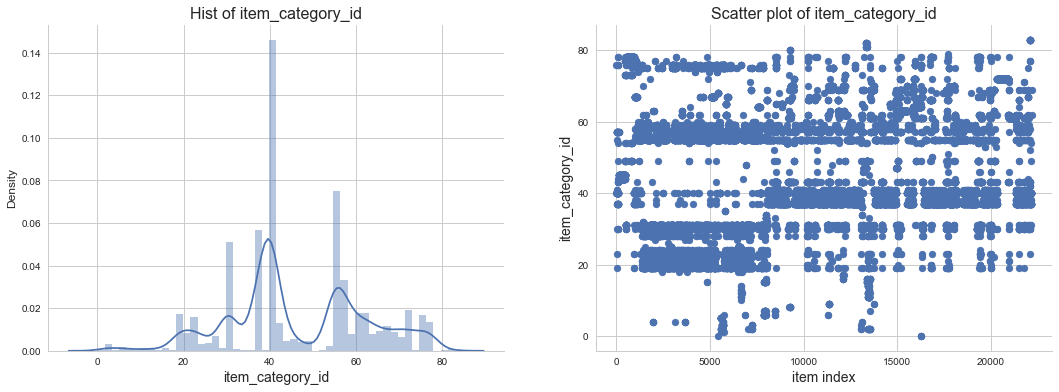

In [160]:
plt.figure(figsize=(18,6))
plt.subplot(121)
sns.set_style("whitegrid")
sns.distplot(items['item_category_id'])
plt.ylabel('Density', fontsize=12)
plt.xlabel('item_category_id', fontsize=14)
plt.title('Hist of item_category_id', fontsize=16)

plt.subplot(122)
plt.scatter(x=items.index, y=items.item_category_id)
plt.xlabel('item index', fontsize=14)
plt.ylabel('item_category_id', fontsize=14)
plt.title('Scatter plot of item_category_id', fontsize=16)
sns.despine()

It looks like far from random. I can recognize some obvious patterns in these plots, for example, 'spikes' in the left plot and 'clusters' in the right plot. So I guess weighted sampling method is the main reason, and the index feature is an important feature.

In [162]:
items.head(10)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


Item names are Russian. I think translating to English may generate some useful features.

## shops

In [163]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [164]:
print("There are %d rows in shops dataset." % len(shops))

There are 60 rows in items dataset.


I think translating to English using Google translate API would help a lot. And I may find more features if I combine it with Google Map. In additon, is there any meaning or pattern of shop_id? Encoding by area?

## train

In [170]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [171]:
train.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [172]:
print("There are %d rows in train dataset." % len(train))

There are 2935849 rows in train dataset.


In [183]:
print("There are %d unique values in date_block_num." % train['date_block_num'].nunique())

There are 34 unique values in date_block_num.


In [191]:
date = pd.to_datetime(train.date, format='%d.%m.%Y')

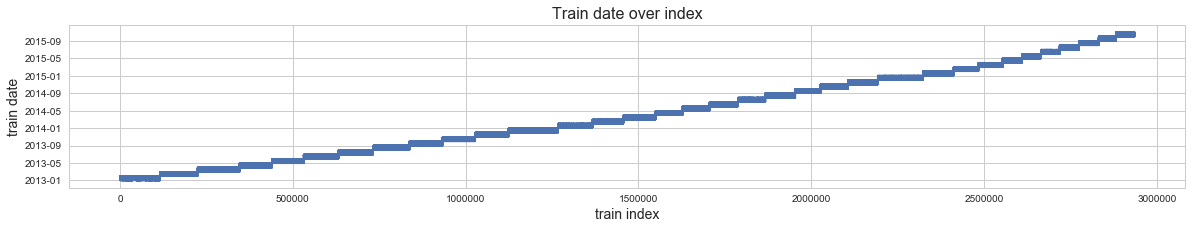

In [193]:
plt.figure(figsize=(20,3))
plt.plot(date)
plt.xlabel('train index', fontsize=14)
plt.ylabel('train date', fontsize=14)
plt.title('Train date over index', fontsize=16)

It shows that train data is sorted by date in ascending order.

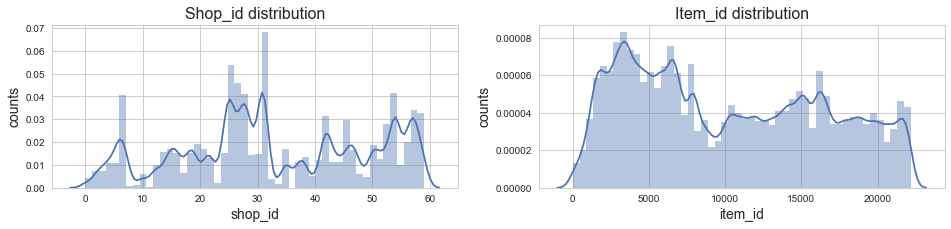

In [235]:
plt.figure(figsize=(16,3))

plt.subplot(121)
sns.distplot(train.shop_id)
plt.xlabel('shop_id', fontsize=14)
plt.ylabel('counts', fontsize=14)
plt.title('Shop_id distribution', fontsize=16)

plt.subplot(122)
sns.distplot(train.item_id)
plt.xlabel('item_id', fontsize=14)
plt.ylabel('counts', fontsize=14)
plt.title('Item_id distribution', fontsize=16)

Not surprise. Shops distribution is not uniform, rather bimodal.

In [220]:
train.item_price.describe()

count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

In [9]:
print("There are %d unique item prices in %d unique items." % (train.item_price.nunique(), train.item_id.nunique()))

There are 19993 unique item prices in 21807 unique items.


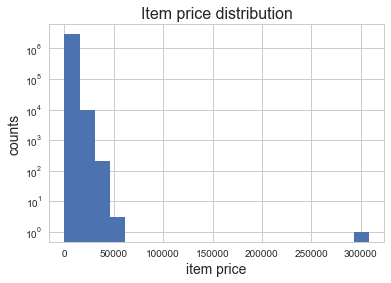

In [251]:
plt.hist(train.item_price, log=True, bins=20)
plt.xlabel('item price', fontsize=14)
plt.ylabel('counts', fontsize=14)
plt.title('Item price distribution', fontsize=16)
plt.show()

Clearly, it is bimodal and skew.

In [245]:
train.item_cnt_day.value_counts()

 1.0      2629372
 2.0       194201
 3.0        47350
 4.0        19685
 5.0        10474
-1.0         7252
 6.0         6338
 7.0         4057
 8.0         2903
 9.0         2177
 10.0        1820
 11.0        1263
 12.0        1083
 13.0         918
 14.0         716
 15.0         638
 16.0         544
 17.0         438
 18.0         391
 20.0         364
 19.0         347
 21.0         290
 22.0         242
 24.0         204
 23.0         198
 25.0         180
 26.0         176
 30.0         147
 28.0         131
 27.0         130
           ...   
 95.0           1
 96.0           1
 102.0          1
 105.0          1
 109.0          1
 112.0          1
 113.0          1
 118.0          1
 128.0          1
 129.0          1
 131.0          1
 132.0          1
 135.0          1
 146.0          1
 200.0          1
 147.0          1
 149.0          1
 153.0          1
 154.0          1
 156.0          1
 157.0          1
 504.0          1
 163.0          1
 164.0          1
 167.0    

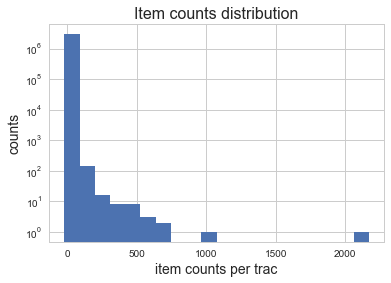

In [250]:
plt.hist(train.item_cnt_day, log=True, bins=20)
plt.xlabel('item counts per trac', fontsize=14)
plt.ylabel('counts', fontsize=14)
plt.title('Item counts distribution', fontsize=16)
plt.show()

## test

In [174]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [180]:
print("There are %d rows in test dataset, about %f percent of train data." % (len(test), 100*len(test)/len(train)))

There are 214200 rows in test dataset, about 7.296016 percent of train data


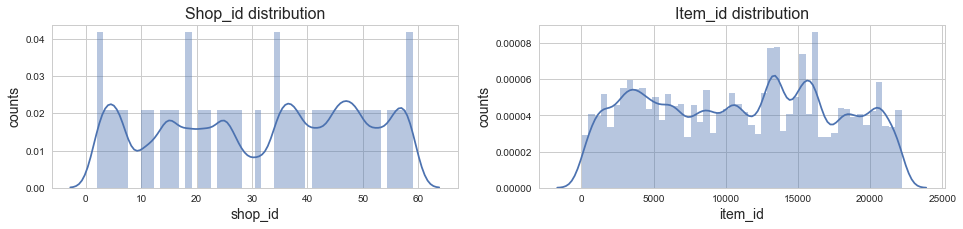

In [236]:
plt.figure(figsize=(16,3))

plt.subplot(121)
sns.distplot(test.shop_id)
plt.xlabel('shop_id', fontsize=14)
plt.ylabel('counts', fontsize=14)
plt.title('Shop_id distribution', fontsize=16)

plt.subplot(122)
sns.distplot(test.item_id)
plt.xlabel('item_id', fontsize=14)
plt.ylabel('counts', fontsize=14)
plt.title('Item_id distribution', fontsize=16)

Shop_id and item_id distributions are different between train and test. Moreover, shop_id distribution is not ordinary. I guess it is related to sampling procedure.

## Deep digging training data

### Shop analysis

In [288]:
# train[['shop_id','date_block_num']]\
#     .pivot(index='shop_id', columns='date_block_num')#, values='value')

    #.agg({'date_block_num': 'count'})
    #.rename(columns={"item_cnt_day": "item_cnt"}) 

In [283]:
shop_running_period =  train.groupby(['shop_id','date_block_num'])\
                            .agg({'item_cnt_day': sum})\
                            .reset_index()\
                            .rename(columns={"item_cnt_day": "item_cnt"})\
                            .pivot(index='shop_id', columns='date_block_num', values='item_cnt')\
                            .apply(lambda x: len(x)-np.isnan(x).sum(), axis=1)
shop_running_period.head()   

shop_id
0     2
1     2
2    34
3    34
4    34
dtype: int64

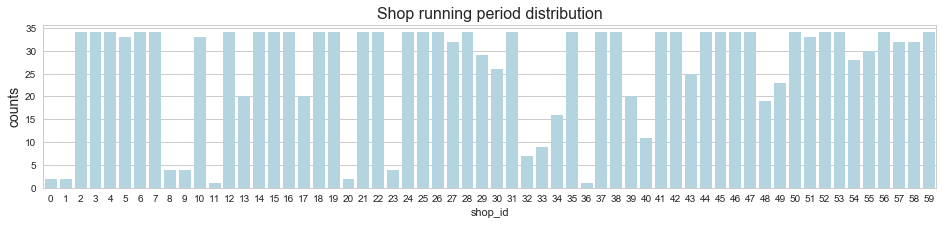

In [297]:
plt.figure(figsize=(16,3))
sns.barplot(x=shop_running_period.index, y = shop_running_period.values, color="lightblue")
plt.ylabel('counts', fontsize=14)
plt.title('Shop running period distribution', fontsize=16)
plt.show()

In [298]:
from matplotlib import collections


yy = np.linspace(0, 2*np.pi, nverts)
ym = np.max(yy)
xx = (0.2 + (ym - yy)/ym)**2 * np.cos(yy - 0.4)*0.5
segs = []
for i in range(ncurves):
    xxx = xx + 0.02*rs.randn(nverts)
    curve = list(zip(xxx, yy*100))
    segs.append(curve)

col = collections.LineCollection(segs, offsets=offs)
ax4.add_collection(col, autolim=True)
col.set_color(colors)
ax4.autoscale_view()
ax4.set_title('Successive data offsets')
ax4.set_xlabel('Zonal velocity component (m/s)')
ax4.set_ylabel('Depth (m)')
# Reverse the y-axis so depth increases downward
ax4.set_ylim(ax4.get_ylim()[::-1])

In [343]:
shop_open_mat = train.groupby(['shop_id','date_block_num'])\
                            .agg({'item_cnt_day': sum})\
                            .reset_index()\
                            .rename(columns={"item_cnt_day": "item_cnt"})\
                            .pivot(index='shop_id', columns='date_block_num', values='item_cnt')\
                            .fillna(0)
                            #.apply(lambda x: x*0+1)\
cm = sns.light_palette("orange", as_cmap=True)
shop_open_mat = shop_open_mat.style.background_gradient(cmap=cm)     
shop_open_mat

I can list the following observations and inferences:
* Shops that don't have sales in a long period, which contains 0,1,8,11,13,17,23,29,30,32,33,40,43,54
* Lead padding zeros indicates established time
* Shop 9 and 20 show strong seasonal sales pattern
* Again, I can see that shop_id shows some clustering pattern

/Users/feynman/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning:

The axisbg attribute was deprecated in version 2.0. Use facecolor instead.



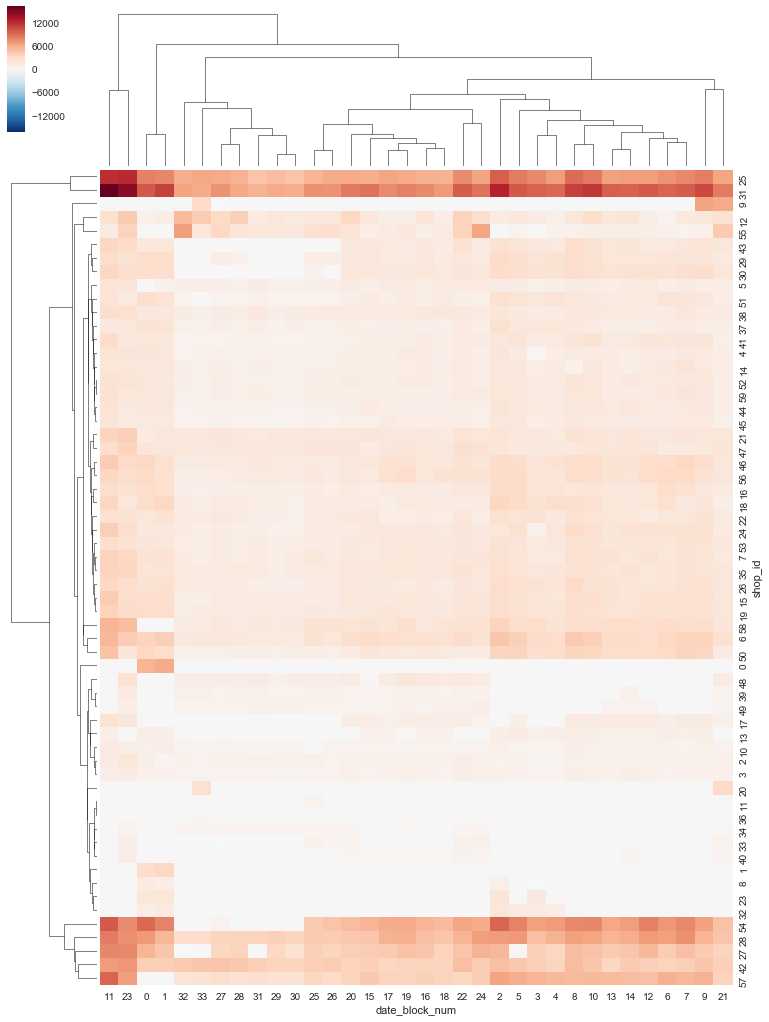

In [341]:
sns.clustermap(shop_open_mat, figsize=(13, 18))
plt.show()

From this plot, patterns are quite obvious. I can recognize at least 3 clusters and seasonal effects.

In [349]:
shop_avg_sales = train.groupby(['shop_id','date_block_num'])\
                            .agg({'item_cnt_day': sum})\
                            .reset_index()\
                            .rename(columns={"item_cnt_day": "item_cnt"})\
                            .pivot(index='shop_id', columns='date_block_num', values='item_cnt')\
                            .apply(np.mean, axis=1)
shop_avg_sales.head()

shop_id
0    5852.500000
1    3155.500000
2     900.588235
3     833.970588
4    1292.411765
dtype: float64

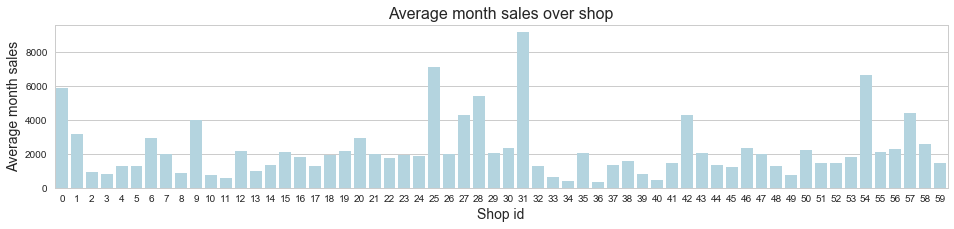

In [358]:
plt.figure(figsize=(16,3))
sns.barplot(x=shop_avg_sales.index, y=shop_avg_sales, color='lightblue')
plt.xlabel('Shop id',fontsize=14)
plt.ylabel('Average month sales',fontsize=14)
plt.title('Average month sales over shop', fontsize=16)
plt.show()

In [371]:
total_sales_over_time = train.groupby(['date_block_num'])\
                    .agg({'item_cnt_day': 'sum'})\
                    .rename(columns={'item_cnt_day': 'item_cnt'})
total_sales_over_time.head()

,item_cnt
date_block_num,
0,131479.0
1,128090.0
2,147142.0
3,107190.0
4,106970.0


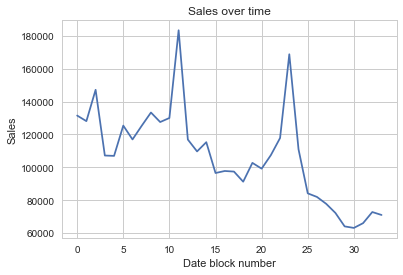

In [374]:
plt.plot(total_sales_over_time)
plt.title('Sales over time')
plt.xlabel('Date block number')
plt.ylabel('Sales')
plt.show()

The trend and seasonality are interesting. Maybe I can use some macroeconomic data to explain and boost performance.

In [381]:
df = train.groupby(['shop_id','date_block_num'])\
                    .agg({'item_cnt_day': 'sum'})\
                    .rename(columns={'item_cnt_day': 'item_cnt'})\
                    .reset_index()
df.head()

,shop_id,date_block_num,item_cnt
0,0,0,5578.0
1,0,1,6127.0
2,1,0,2947.0
3,1,1,3364.0
4,2,0,1146.0


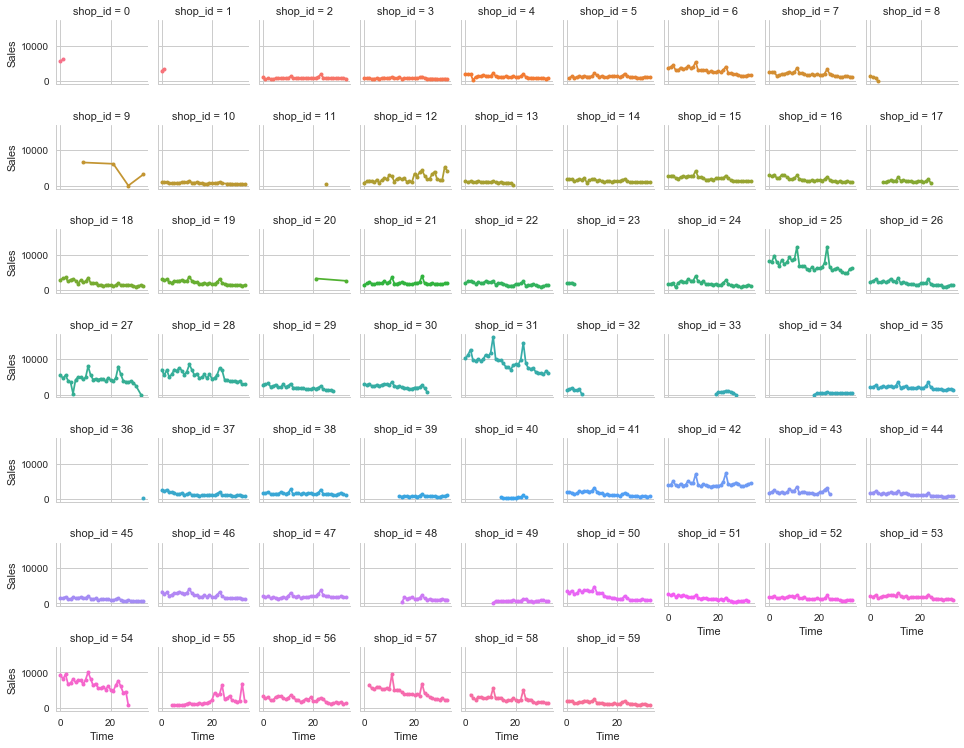

In [402]:
grid = sns.FacetGrid(df, col="shop_id", hue="shop_id", col_wrap=9, size=1.5)
grid.map(plt.plot, "date_block_num", "item_cnt", marker="o", ms=4)
grid.set_axis_labels("Time")
grid.set_ylabels("Sales")

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)

In [4]:
#translator.trans_details('ru', 'en', '!Якутск')


## Generated features explory

In [4]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    int8_features = ['shop_id', 'item_category_id', 'date_block_num', 'ID', 'shop_running_months','recent_continuous_no_sales_months']
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    safe_cast_int8_cols = [c for c in df if c in int8_features]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    df[safe_cast_int8_cols] = df[safe_cast_int8_cols].astype(np.int8)
    
    return df

def generate_target_features(data):
    index_cols=['shop_id', 'item_id', 'date_block_num'] #'item_category_id',
    item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()
    
    data = pd.merge(data, item_category_mapping, how='left', on='item_id')
        
    # For every month we create a grid from all shops/items combinations from that month
    grid = []
    for block_num in data['date_block_num'].unique():
        cur_shops = data.loc[data['date_block_num'] == block_num, 'shop_id'].unique()
        cur_items = data.loc[data['date_block_num'] == block_num, 'item_id'].unique()
        grid.append(np.array(list(itertools.product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

    # Turn the grid into a dataframe
    grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)   
    grid = pd.merge(grid, item_category_mapping, how='left', on='item_id')

    # Groupby data to get shop-item-month aggregates
    gb = data.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
    # Fix column names
    gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
    # Join it to the grid
    all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)
    
    # Same as above but with shop-month aggregates
    gb = data.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
    gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
    all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

    # Same as above but with item-month aggregates
    gb = data.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
    gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
    all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

    
    # Same as above but with category-month aggregates
    gb = data.groupby(['item_category_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_category':'sum'}})
    gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
    # Category for each item 
    all_data = pd.merge(all_data, gb, how='left', on=['item_category_id', 'date_block_num']).fillna(0)
    
    
    # Downcast dtypes to save memory
    all_data = downcast_dtypes(all_data)
    del grid, gb 
    gc.collect()
    return all_data

def generate_lagged_features(all_data, is_test=False):
    index_cols=['shop_id', 'item_id', 'item_category_id','date_block_num']
    cols_to_rename = list(all_data.columns.difference(index_cols)) 
    if is_test:
        shift_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
        all_data['date_block_num'] += 1
    else:
        shift_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

    for month_shift in shift_range:
        train_shift = all_data[index_cols + cols_to_rename].copy()
        train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
        if is_test:
            foo = lambda x: '{}_lag_{}'.format(x, month_shift+1) if x in cols_to_rename else x
        else:
            foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
        train_shift = train_shift.rename(columns=foo)
        all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

    del train_shift

    if is_test:
    # update lagged 1 columns
        for col in cols_to_rename:
            #all_data = all_data.rename(columns=(lambda x: '{}_lag_{}'.format(x, 1) if x in cols_to_rename else x))
            all_data['{}_lag_{}'.format(col, 1)] = all_data[col]
    else:
    # Don't use old data from year 2013 for training
        all_data = all_data[all_data['date_block_num'] >= 12]

    # List of all lagged features
    #fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 

    all_data = downcast_dtypes(all_data)
    gc.collect()
    return all_data

def generate_item_price_statistic_features(all_data, train):
    item_price_statistic_encoding = train.groupby(['item_id']).item_price\
                        .agg([np.mean, np.std, np.max, np.min, len, lambda x: x.max()-x.min()])\
                        .fillna(0)\
                        .rename(columns={'<lambda>': 'item_price_diff',
                                        'mean': 'item_price_mean',
                                        'std': 'item_price_std',
                                        'amax': 'item_price_max',
                                        'amin': 'item_price_min',
                                        'len': 'item_price_count'})\
                        .reset_index()
    all_data = pd.merge(all_data, item_price_statistic_encoding, on='item_id', how='left').fillna(0)
    all_data = downcast_dtypes(all_data)
    del item_price_statistic_encoding
    gc.collect()
    return all_data

def generate_shop_item_price_statistic_features(all_data, train):
    shop_item_price_encoding = train.groupby(['shop_id', 'item_id']).item_price\
                        .agg([np.mean, np.std, np.max, np.min, len, lambda x: x.max()-x.min()])\
                        .fillna(0)\
                        .rename(columns={'<lambda>': 'shop_item_price_diff',
                                        'mean': 'shop_item_price_mean',
                                        'std': 'shop_item_price_std',
                                        'amax': 'shop_item_price_max',
                                        'amin': 'shop_item_price_min',
                                        'len': 'shop_item_price_count'})\
                        .reset_index()
    shop_item_price_statistic_features = ['shop_item_price_mean', 'shop_item_price_std', 'shop_item_price_max', 'shop_item_price_min', 'shop_item_price_count','shop_item_price_diff']
    df_shop_item_price_encoding.head()
    all_data = pd.merge(all_data, shop_item_price_encoding, on=['shop_id', 'item_id'], how='left').fillna(0)
    all_data = downcast_dtypes(all_data)
    del shop_item_price_encoding
    gc.collect()
    return all_data

def get_train_val_test_df(train, test, is_modeling=True):
    to_drop_train_cols = ['target', 'target_shop','target_category', 'target_item']
    to_drop_test_cols = ['ID','target', 'target_shop','target_category', 'target_item']

    all_data = generate_lagged_features(generate_target_features(train))
    all_data = get_sales_frequency_features(all_data)
    all_data = generate_item_price_statistic_features(all_data, train)
    #all_data = generate_shop_item_price_statistic_features(all_data, train)

    dates = all_data['date_block_num']
    last_block = dates.max()
    dates_train = dates[dates <  last_block]
    dates_val  = dates[dates == last_block]
    
    if is_modeling:
        X_train = downcast_dtypes(all_data.loc[dates <  last_block].drop(to_drop_train_cols, axis=1))
        X_val =  downcast_dtypes(all_data.loc[dates == last_block].drop(to_drop_train_cols, axis=1))

        y_train = all_data.loc[dates <  last_block, 'target'].clip(0,20).values
        y_val =  all_data.loc[dates == last_block, 'target'].clip(0,20).values
        
        return X_train, y_train, X_val, y_val
    else:
        X_train_final = downcast_dtypes(all_data.drop(to_drop_train_cols, axis=1))
        y_train_final = all_data.target.clip(0,20).values

        # generate test predict dataset
        all_data_test = generate_lagged_features(generate_target_features(train), is_test=True)
        all_data_test = get_sales_frequency_features(all_data_test)
        all_data_test = generate_item_price_statistic_features(all_data_test, train)

        X_test = downcast_dtypes(test.set_index(['shop_id','item_id'])\
            .join(all_data_test.loc[all_data_test['date_block_num'] == 34]\
            .set_index(['shop_id','item_id']), how='left')\
            .fillna(0)\
            .reset_index()\
            .drop(to_drop_test_cols, axis=1))
        
        X_test = X_test[X_train_final.columns]
        
        return X_train_final, y_train_final, X_test

def get_sales_frequency_features(all_data):
    all_data = all_data.set_index('shop_id')\
                        .join(all_data[['shop_id', 'target_shop','date_block_num']]\
                            .drop_duplicates()\
                            .pivot(index='shop_id', columns='date_block_num', values='target_shop')\
                            .apply(lambda x: len(x)-np.isnan(x).sum(), axis=1)\
                            .to_frame()\
                            .rename(columns={0: 'shop_running_months'})\
                            .astype({'shop_running_months': 'i1'}))\
                        .reset_index()
            
    all_data = all_data.set_index('shop_id')\
                        .join(all_data[['shop_id', 'target_shop','date_block_num']]\
                            .drop_duplicates()\
                            .pivot(index='shop_id', columns='date_block_num', values='target_shop')\
                            .apply(np.isnan)\
                            .apply(lambda s:len(s)-(s.index * s.apply(lambda x: int(x==False))).max()-1,axis=1)\
                            .to_frame()\
                            .rename(columns={0: 'shop_continuous_no_sales_months'})\
                            .astype({'shop_continuous_no_sales_months': 'i1'}))\
                        .reset_index() 
    
    all_data = downcast_dtypes(all_data)
    return all_data

In [7]:
X_train_final, y_train_final, X_test = get_train_val_test_df(train,test, False)

/Users/xuxiaobin/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning:

using a dict with renaming is deprecated and will be removed in a future version



### check lagged features

In [117]:
def generate_moving_features(all_data):
    lagged_features = [column for column in X_train_final.columns.values if 'target_lag_' in column]
    all_data['target_ma3'] = all_data[lagged_features[0:3]].apply(np.mean ,axis=1)
    all_data['target_ma6'] = all_data[lagged_features[0:6]].apply(np.mean ,axis=1)
    all_data['target_ma9'] = all_data[lagged_features[0:9]].apply(np.mean ,axis=1)
    all_data['target_ma12'] = all_data[lagged_features[0:12]].apply(np.mean ,axis=1)
    all_data = downcast_dtypes(all_data)
    return all_data

In [119]:
X_train_final = generate_moving_features(X_train_final)
X_train_final[moving_features].head()

,item_price_max
0,749.0
1,1599.0
2,399.0
3,699.0
4,299.0


In [124]:
X_train_final.head()

,shop_id,item_id,date_block_num,item_category_id,target_lag_1,target_category_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_category_lag_2,...,item_price_mean,item_price_std,item_price_max,item_price_min,item_price_count,item_price_diff,target_ma3,target_ma6,target_ma9,target_ma12
0,2,10297,12,37,1.0,9959.0,42.0,1322.0,0.0,7420.0,...,714.789734,73.217537,749.0,474.000000,161.0,275.000000,0.333333,0.166667,0.111111,0.083333
1,2,10296,12,38,0.0,2052.0,24.0,1322.0,0.0,0.0,...,1473.739136,231.561172,1599.0,734.619995,141.0,864.380005,0.000000,0.000000,0.000000,0.000000
2,2,10298,12,40,4.0,28598.0,369.0,1322.0,3.0,25433.0,...,272.729889,114.339310,399.0,60.480000,2540.0,338.519989,2.333333,1.166667,0.777778,0.583333
3,2,10300,12,37,1.0,9959.0,54.0,1322.0,4.0,7420.0,...,587.519470,144.256149,699.0,281.890015,606.0,417.109985,1.666667,0.833333,0.555556,0.416667
4,2,10284,12,57,0.0,1425.0,4.0,1322.0,0.0,1054.0,...,287.195129,37.822201,299.0,167.000000,123.0,132.000000,0.000000,0.000000,0.000000,0.000000


In [79]:
all_data = generate_target_features(train)

/Users/xuxiaobin/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning:

using a dict with renaming is deprecated and will be removed in a future version



In [91]:
all_data[all_data.date_block_num >= 12].groupby(['shop_id', 'date_block_num'],as_index=False).agg({'target':'sum'}).head(10)

,shop_id,date_block_num,target
0,2,12,890.0
1,2,13,911.0
2,2,14,990.0
3,2,15,791.0
4,2,16,910.0
5,2,17,957.0
6,2,18,838.0
7,2,19,956.0
8,2,20,920.0
9,2,21,945.0


In [96]:
X_train_final[X_train_final['target_shop_lag_1'] != 0][['shop_id', 'date_block_num', 'target_shop_lag_1']]\
    .drop_duplicates()\
    .sort_values(['shop_id','date_block_num']).head(10)

,shop_id,date_block_num,target_shop_lag_1
0,2,12,1322.0
7551,2,13,890.0
14685,2,14,911.0
21827,2,15,990.0
28601,2,16,791.0
35286,2,17,910.0
41968,2,18,957.0
48578,2,19,838.0
54941,2,20,956.0
61012,2,21,920.0


In [33]:
y_train_final.shape, X_train_final.shape

((6425094,), (6425094, 60))

In [95]:
?X_train_final.where

# Summary

In [ ]:
# Imports the Google Cloud client library
from google.cloud import translate

# Instantiates a client
translate_client = translate.Client()

# The text to translate
text = u'Hello, world!'
# The target language
target = 'ru'

# Translates some text into Russian
translation = translate_client.translate(
    text,
    target_language=target)

print(u'Text: {}'.format(text))
print(u'Translation: {}'.format(translation['translatedText']))